# **6) Model 4**

In [6]:
import os
import csv
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, lit, pandas_udf
from pyspark.sql.functions import PandasUDFType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Preprocessing for #4:

In [3]:

df = pd.read_csv('wesad_merged_df.csv')

In [18]:

df = pd.read_csv('wesad_merged_df.csv')

# create binary label: 1 if stress (label == 2), else 0
df['stress_binary'] = (df['label'] == 2).astype(int)

### Random Forest: Sensor Data + Survey Data, Binary

Matplotlib created a temporary cache directory at /scratch/tsanchez/job_40043468/matplotlib-pedjnlcn because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<Figure size 800x600 with 0 Axes>

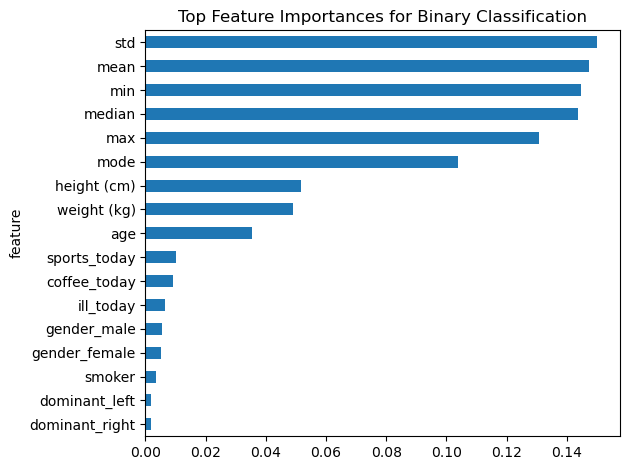


Train accuracy: 0.9718
Test accuracy: 0.8965

Classification report (Test):

              precision    recall  f1-score   support

           0     0.9302    0.9373    0.9337     30101
           1     0.7742    0.7537    0.7638      8591

    accuracy                         0.8965     38692
   macro avg     0.8522    0.8455    0.8488     38692
weighted avg     0.8956    0.8965    0.8960     38692



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

df = pd.read_csv('wesad_merged_df.csv')

# create binary label column for stress 
df['stress_binary'] = (df['label'] == 2).astype(int)

# Remove features with 0 importance
features_to_drop = ['coffee_last_hour', 'smoked_last_hour']

X = df.drop(columns=['subject', 'modality', 'label', 'stress_binary'] + features_to_drop)
y = df['stress_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest 
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=23,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)


# Plot top 20 feat
plt.figure(figsize=(8, 6))
feat_imp_df.head(20).plot(kind='barh', x='feature', y='importance', legend=False)
plt.title('Top Feature Importances for Binary Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 8. Evaluate model performance
y_pred = rf.predict(X_test)
train_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

print(f'\nTrain accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')
print('\nClassification report (Test):\n')
print(classification_report(y_test, y_pred, digits=4))

### Post-model analysis

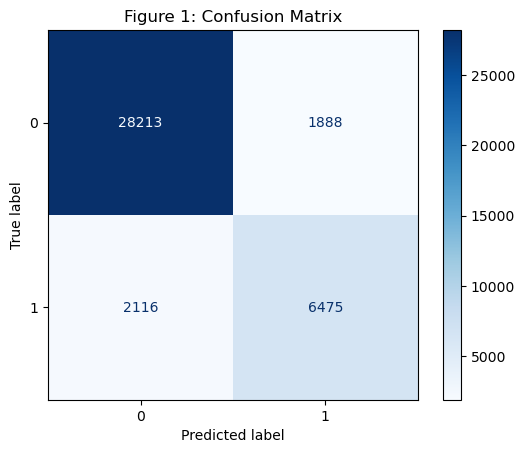

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title("Figure 1: Confusion Matrix")
plt.show()

The confusion matrix illustrates the performance of the binary classification model on the test set. The model correctly classified 28,213 samples as class 0 (true negatives) and 6,475 samples as class 1 (true positives). It misclassified 1,888 samples as class 1 when they were actually class 0 (false positives) and 2,116 samples as class 0 when they were actually class 1 (false negatives). This indicates strong performance on the majority class (class 0) and reasonable performance on the minority class (class 1), with some room for improvement in identifying class 1 samples.

# For Results: Binary Classification
----

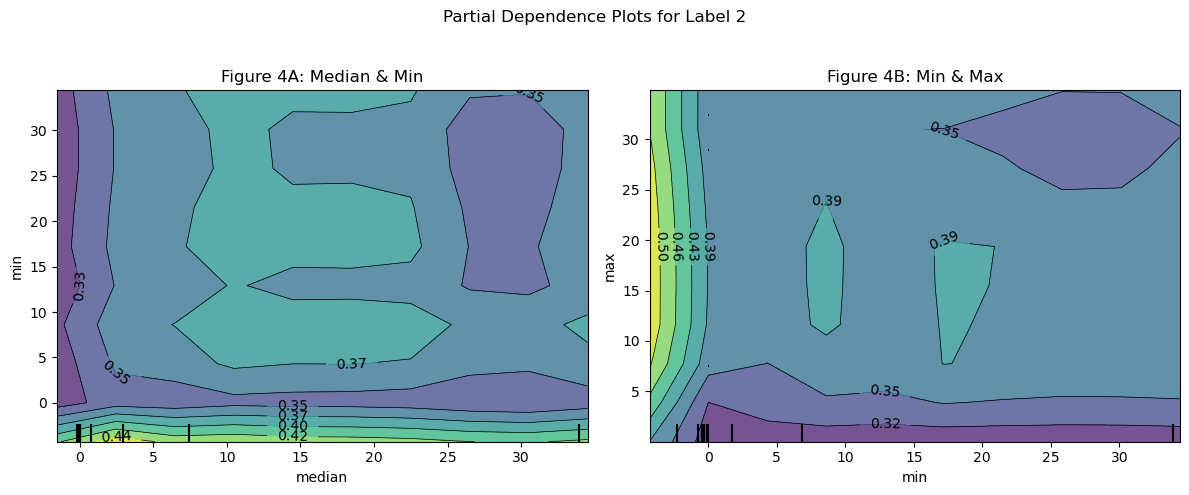

In [12]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# List of feature pairs to plot for label 2
feature_pairs = [
    ('median', 'min'),  
    ('min', 'max'),     
]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

titles = ["Figure 4A", "Figure 4B"]

for i, features in enumerate(feature_pairs):
    disp = PartialDependenceDisplay.from_estimator(
        rf,                      # Your trained RandomForestClassifier
        X,          # Test data with same columns as training
        features=[features],     # Must be a list of tuples
        target=1,                # 2 = label 2 (third class)
        kind='average',
        grid_resolution=10,
        ax=axs[i]
    )
    axs[i].set_title(f"{titles[i]}: {features[0].capitalize()} & {features[1].capitalize()}")

plt.suptitle("Partial Dependence Plots for Label 2")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Overall the partial dependence plots in Figures 4A and 4B demonstrate that the predicted probability for Label 2 can reach up to 0.50 for the feature combination of Min and Max.

* the model exhibits greater confidence in predicting Label 2 for some regions of the feature space. This is reflected by higher predicted probabilities when certain values of "min", "max", or "median" are present.


This increase in probability indicates that the binary classification model is more confident in assigning Label 2 under favorable feature conditions, reflecting both increased model sensitivity and the impact of focusing on a single class versus distributing probabilities across multiple classes.

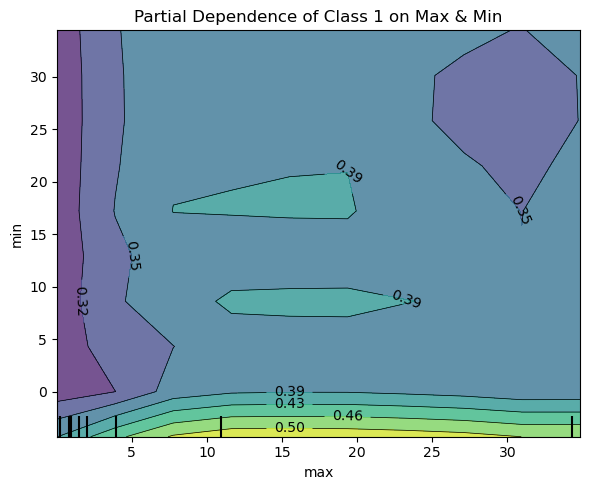

In [11]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 5))

PartialDependenceDisplay.from_estimator(
    rf,
    X,
    features=[('max', 'min')],
    target=1,  # label 1 for binary classification
    kind='average',
    grid_resolution=10,
    ax=ax
)
ax.set_title("Partial Dependence of Class 1 on Max & Min")
plt.tight_layout()
plt.show()